# SST and SST difference from WOA23

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-25km-paper-1/issues/9

In [118]:
# Parameters – this is the ONLY place you should edit
# when switching models / experiments / obs datasets.

### USER EDIT start

# ESM datastore (model output) – change this for a different run/model
esm_file = "/g/data/zv30/non-cmip/ACCESS-CM3/cm3-run-11-08-2025-25km-beta-om3-new-um-params/cm3-demo-datastore/cm3-demo-datastore.json"

# What physical field you want, in CF terms (stays the same across models)
variable_standard_name = "sea_surface_temperature"

# Fallback variable name to use if the catalog doesn’t expose standard_name
fallback_variable_name = "tos"

# Reference / observational dataset (we'll use this later when we get to the WOA block)
obs_file_pattern = "/g/data/ik11/inputs/access-om3/woa23/025/2025.08.26/woa23_ts_*"
obs_var_name = "temp"

# Frequency depends on the datastore you’re using:
data_frequency = "1mon"

# Optional special-case switches (e.g. 25 km quirks)
APPLY_OBS_25KM_Y_SLICE = False

# Plot settings
dpi = 300

### USER EDIT stop


import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"] = dpi

plotfolder = f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

print("ESM datastore path:", esm_file)
print("Plot folder path:", plotfolder)
print("Obs file pattern:", obs_file_pattern)

ESM datastore path: /g/data/zv30/non-cmip/ACCESS-CM3/cm3-run-11-08-2025-25km-beta-om3-new-um-params/cm3-demo-datastore/cm3-demo-datastore.json
Plot folder path: /g/data/tm70/ek4684/access-om3-paper-figs/
Obs file pattern: /g/data/ik11/inputs/access-om3/woa23/025/2025.08.26/woa23_ts_*


In [120]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cftime
import os
import cmocean as cm
import cartopy.feature as cft
from textwrap import wrap
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

In [121]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33071 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:38557' processes=4 threads=4, memory=18.00 GiB>

### Define plot function

In [122]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [123]:
def select_variable(
    datastore,
    variable_standard_name,
    fallback_variable_name=None,
    data_frequency=None,
):
    """
    Select a variable (e.g. SST) from an intake-esm datastore in a model-agnostic way.

    Parameters
    ----------
    datastore : intake_esm.core.esm_datastore
        The opened ESM datastore.
    variable_standard_name : str
        CF standard_name to look for first, e.g. "sea_surface_temperature".
    fallback_variable_name : str or None
        Variable name to try if CF lookup fails, e.g. "tos".
    data_frequency : str or None
        Frequency filter to pass to the catalog search, e.g. "1mon", "1day".
        If not found with this frequency, we automatically retry without it.

    Returns
    -------
    da_model : xarray.DataArray
        The selected DataArray containing the variable.
    """

    # Helper: search with frequency, and if nothing is found, retry without frequency
    def _search_with_optional_frequency(datastore, base_kwargs, **extra):
        search_kwargs = dict(base_kwargs)
        search_kwargs.update(extra)

        cat = datastore.search(**search_kwargs)
        if len(cat.df) == 0 and "frequency" in search_kwargs:
            # Retry without frequency
            search_kwargs.pop("frequency")
            cat = datastore.search(**search_kwargs)
            if len(cat.df) > 0:
                print("No matches with frequency filter; retrying without 'frequency'.")
        return cat

    # Base search kwargs shared by all calls
    base_search = {}
    if data_frequency is not None:
        base_search["frequency"] = data_frequency

    # --- 1) Try CF-based selection via standard_name ---
    try:
        cat = _search_with_optional_frequency(
            datastore,
            base_search,
            variable_standard_name=variable_standard_name,
        )
        if len(cat.df) == 0:
            raise ValueError("No entries with given standard_name in catalog")

        ds_model = cat.to_dask(
            xarray_open_kwargs=dict(
                chunks={"time": -1},
                decode_timedelta=True,
                use_cftime=True,
            ),
            xarray_combine_by_coords_kwargs=dict(
                compat="override",
                data_vars="minimal",
                coords="minimal",
            ),
        )

        da_model = ds_model.cf[variable_standard_name]
        print("Selected variable by standard_name:", variable_standard_name)
        return da_model

    except Exception as e:
        print("CF-based standard_name lookup failed:", repr(e))

    # --- 2) Try explicit fallback variable name, if provided ---
    if fallback_variable_name is not None:
        try:
            cat = _search_with_optional_frequency(
                datastore,
                base_search,
                variable=fallback_variable_name,
            )
            if len(cat.df) == 0:
                raise ValueError(f"No entries with variable={fallback_variable_name} in catalog")

            ds_model = cat.to_dask(
                xarray_open_kwargs=dict(
                    chunks={"time": -1},
                    decode_timedelta=True,
                    use_cftime=True,
                ),
                xarray_combine_by_coords_kwargs=dict(
                    compat="override",
                    data_vars="minimal",
                    coords="minimal",
                ),
            )

            da_model = ds_model[fallback_variable_name]
            print("Selected variable by fallback name:", fallback_variable_name)
            return da_model

        except Exception as e:
            print("Fallback variable lookup failed:", repr(e))

    # --- 3) Last resort: inspect catalog metadata ONLY (no data opens) ---
    cat_any = _search_with_optional_frequency(datastore, base_search)

    candidates = set()
    if "variable" in cat_any.df.columns:
        for entry in cat_any.df["variable"]:
            if isinstance(entry, str):
                candidates.add(entry)
            else:
                # Often 'variable' is a list of names
                try:
                    candidates.update(entry)
                except TypeError:
                    pass

    # Try common SST variable names in a sensible order
    common_sst_names = ["tos", "temp", "thetao", "sst"]
    for name in common_sst_names:
        if name in candidates:
            print(f"Inferred SST variable name '{name}' from catalog candidates.")
            cat = _search_with_optional_frequency(
                datastore,
                base_search,
                variable=name,
            )
            ds_model = cat.to_dask(
                xarray_open_kwargs=dict(
                    chunks={"time": -1},
                    decode_timedelta=True,
                    use_cftime=True,
                ),
                xarray_combine_by_coords_kwargs=dict(
                    compat="override",
                    data_vars="minimal",
                    coords="minimal",
                ),
            )
            da_model = ds_model[name]
            return da_model

    # If we still haven't found anything, give up with a helpful error
    raise RuntimeError(
        "Could not automatically determine the requested variable.\n"
        f"Looked for standard_name='{variable_standard_name}'"
        + (f" and fallback_variable_name='{fallback_variable_name}'" if fallback_variable_name else "")
        + ".\nVariables listed in this datastore matching your search: "
        f"{sorted(candidates)}"
    )

In [124]:
def plot(dat, title=None, **kwargs):
    """
    Plot a 2D field on a Robinson map in a model-agnostic way.
    Uses CF axes (X/Y) when possible, falls back to last two dims otherwise.
    """
    long_name = dat.attrs.get("long_name", "")
    units = dat.attrs.get("units", "")

    if title is None:
        title = long_name

    # If this is still carrying pint units, strip them for plotting
    try:
        dat_to_plot = dat.pint.dequantify()
    except Exception:
        dat_to_plot = dat

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

    # Work out which dims to use for x/y in a CF-aware but robust way
    try:
        x_dim = dat_to_plot.cf.axes["X"][0]
        y_dim = dat_to_plot.cf.axes["Y"][0]
    except Exception:
        # Fallback: assume last two dims are (y, x)
        y_dim, x_dim = dat_to_plot.dims[-2], dat_to_plot.dims[-1]

    dat_to_plot.plot.contourf(
        ax=ax,
        x=x_dim,
        y=y_dim,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={
            "label": "\n".join(wrap(f"{long_name} [{units}]", 45)),
            "fraction": 0.03,
            "aspect": 15,
            "shrink": 0.7,
        },
        **kwargs,
    )

    # Add blue marble land (assuming blue_marble & blue_marble_extent defined)
    ax.imshow(
        blue_marble,
        extent=blue_marble_extent,
        transform=ccrs.PlateCarree(),
        origin="upper",
    )

    plt.title(title)

### Load and plot data from ESM datastore

In [125]:
exptname=os.path.basename(os.path.dirname(esm_file))
print("Experiment name:", exptname)

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

Experiment name: cm3-demo-datastore


In [126]:
# Try to obtain longitude and latitude in a model-agnostic way

def get_lon_lat_from_catalog(datastore):
    """Return (lon, lat) DataArrays using CF metadata where possible."""
    
    # --- 1) Try to detect CF coords directly on any dataset ---
    try:
        ds_sample = datastore.search().to_dask()  # load a small representative dataset
        lon = ds_sample.cf["longitude"]
        lat = ds_sample.cf["latitude"]
        return lon, lat
    except Exception:
        pass

    # --- 2) Try known OM3/OM2 names ---
    try:
        ds_grid = datastore.search(variable=["geolon", "geolat"]).to_dask()
        return ds_grid["geolon"], ds_grid["geolat"]
    except Exception:
        pass

    # --- 3) Fallback: no lon/lat found ---
    raise ValueError("Could not determine longitude/latitude from this datastore.")

# Use the function
lon, lat = get_lon_lat_from_catalog(datastore)

print("Longitude dims:", lon.dims)
print("Latitude dims:", lat.dims)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:99: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:99: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:99: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cfti

Longitude dims: ('yh', 'xh')
Latitude dims: ('yh', 'xh')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:99: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)


In [127]:
da_model = select_variable(
    datastore,
    variable_standard_name=variable_standard_name,
    fallback_variable_name=fallback_variable_name,
    data_frequency=data_frequency,
)
print("Selected variable:", da_model.name)
print("dims:", da_model.dims)

Selected variable by standard_name: sea_surface_temperature
Selected variable: tos
dims: ('time', 'yh', 'xh')


In [128]:
# Discover lon/lat from the catalog (using the helper we wrote earlier)
lon, lat = get_lon_lat_from_catalog(datastore)

# Ensure model_all has CF longitude/latitude coords
try:
    # If CF coords already exist, just use them
    _ = da_model.cf["longitude"]
    _ = da_model.cf["latitude"]
    model_all = da_model
    print("Using existing CF longitude/latitude on da_model.")
except KeyError:
    # Otherwise, attach the lon/lat we discovered
    model_all = da_model.cf.assign_coords(
        {
            "longitude": lon,
            "latitude": lat,
        }
    )
    print("Attached longitude/latitude from catalog grid variables.")

print("model_all dims:", model_all.dims)


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:99: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:99: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:99: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cfti

Using existing CF longitude/latitude on da_model.
model_all dims: ('time', 'yh', 'xh')


In [129]:
# Put model time axis on a common calendar
model_all = model_all.convert_calendar("proleptic_gregorian", use_cftime=True)

# Optional: inspect time coverage
print("Initial date:", model_all.time.values[0])
print("Final date:",   model_all.time.values[-1])

# Choose the final date for the averaging window
# Option 1: fixed date to match OM2 IAF:
datestop = cftime.DatetimeProlepticGregorian(
    2018, 12, 14, 12, 0, 0, 0, has_year_zero=True
)

# (If you ever want “whatever the last model date is”, you could do:)
# datestop = model_all.time.values[-1]

# Compute "last 10 years" start date
datelist = list(cftime.to_tuple(datestop))
datelist[0] -= 10  # subtract 10 years
datestart = cftime.datetime(*datelist, calendar=datestop.calendar)

timerange = slice(datestart, datestop)
print("Averaging window:", timerange)

# Restrict model to this 10-year window
model_window = model_all.cf.sel(time=timerange)
print("Windowed dims:", model_window.dims)

Initial date: 1981-01-16 12:00:00
Final date: 2030-12-16 12:00:00
Averaging window: slice(cftime.datetime(2008, 12, 14, 12, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=True), cftime.DatetimeProlepticGregorian(2018, 12, 14, 12, 0, 0, 0, has_year_zero=True), None)
Windowed dims: ('time', 'yh', 'xh')


In [130]:
%%time
model = (
    model_window
    .cf.mean("time")          # CF-aware: whatever the time dim is called
    .pint.quantify()          # attach Pint units from attrs["units"]
    .pint.to("degC")          # convert to degrees Celsius
    .pint.dequantify()        # back to plain DataArray for plotting / saving
)

print("Final model dims:", model.dims)
print("Final model units:", model.attrs.get("units"))

Final model dims: ('yh', 'xh')
Final model units: degree_Celsius
CPU times: user 7.83 ms, sys: 2.58 ms, total: 10.4 ms
Wall time: 9.87 ms


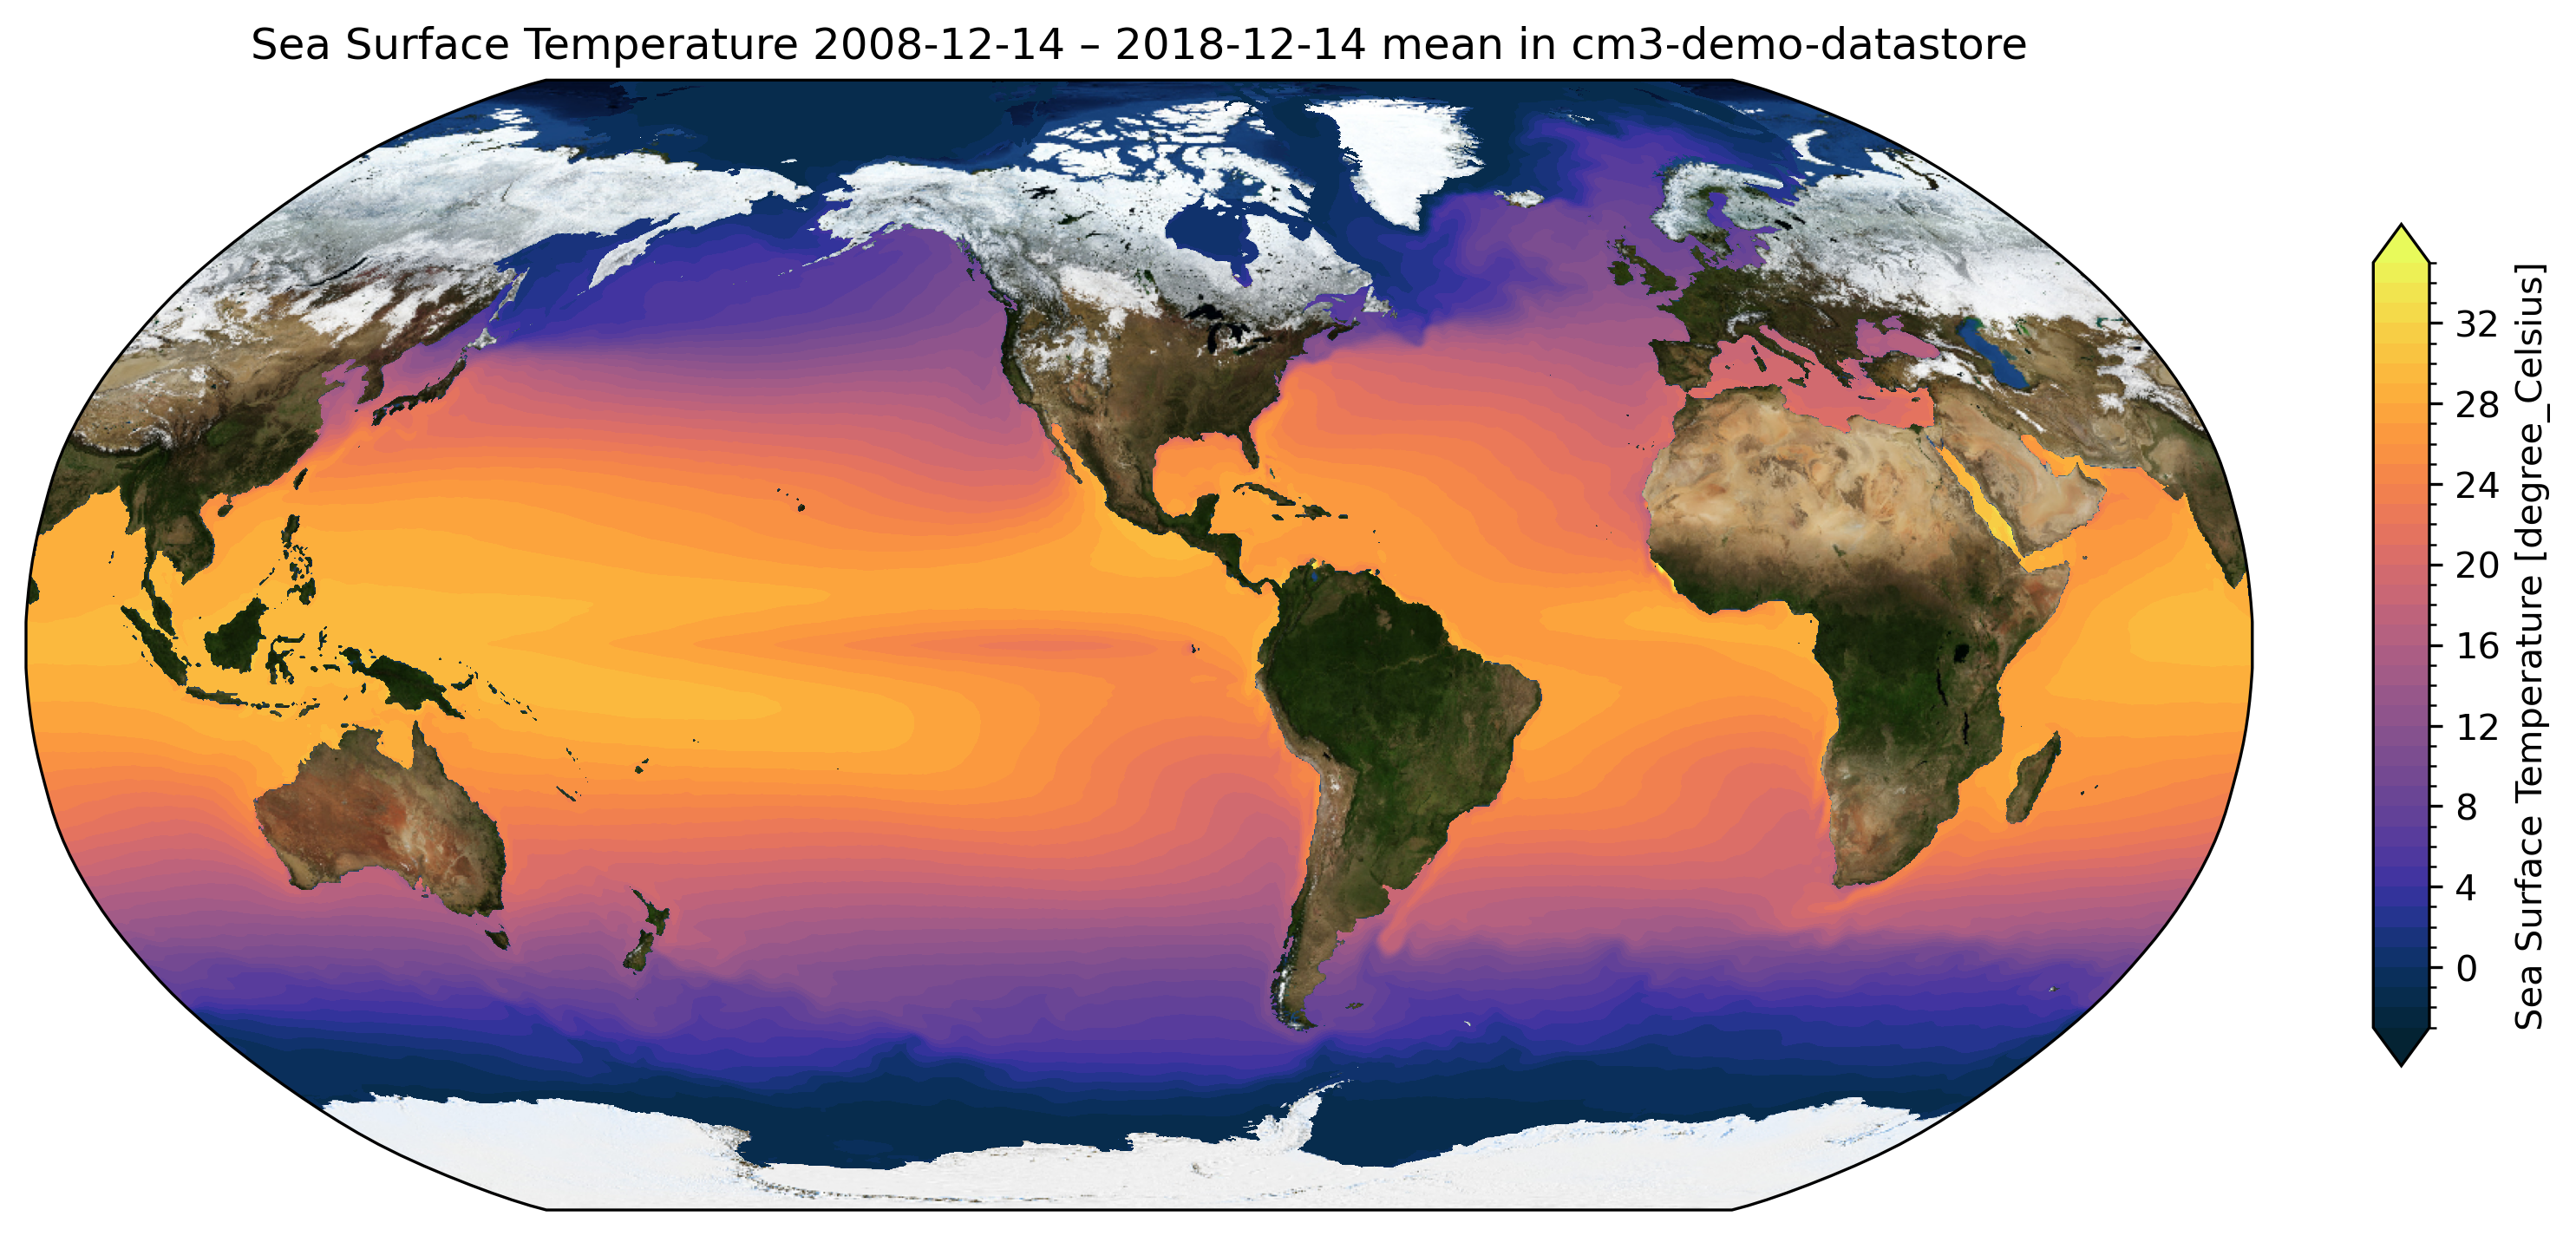

In [131]:
long_name = model.attrs.get("long_name", "SST")

plot(
    model,
    levels=39,
    vmin=-3,
    vmax=35,
    extend="both",
    cmap=cm.cm.thermal,
    title=(
        f"{long_name} "
        f"{datestart.strftime('%Y-%m-%d')} – {datestop.strftime('%Y-%m-%d')} "
        f"mean in {exptname}"
    ),
)


### Load data from WOA23 (annual mean; Jan is ACCESS-OM3 initial condition)

In [132]:
# Load observational / reference SST (e.g. WOA23) in a model-agnostic way

# 1) Open the obs dataset using the pattern & var name from the config cell
ds_obs = xr.open_mfdataset(
    obs_file_pattern,
    chunks={"time": -1},
)

da_obs = ds_obs[obs_var_name]

# 2) Take surface level + time mean using CF-aware indexing
#    (this will work as long as depth/time have CF metadata)
try:
    da_obs_sfc = da_obs.cf.isel(Z=0)          # first depth level
except Exception:
    # Fallback: if depth is literally called 'depth'
    da_obs_sfc = da_obs.isel(depth=0)

obs = da_obs_sfc.cf.mean("time")

# 3) Make sure longitude / latitude coords are available in CF terms
try:
    _ = obs.cf["longitude"]
    _ = obs.cf["latitude"]
except KeyError:
    # If obs uses plain 'lon'/'lat' dims, expose them as CF coords
    rename_dict = {}
    if "lon" in obs.dims:
        rename_dict["lon"] = "longitude"
    if "lat" in obs.dims:
        rename_dict["lat"] = "latitude"
    if rename_dict:
        obs = obs.rename(rename_dict)

# 4) Optional hack for the 25 km issue (only if needed)
if APPLY_OBS_25KM_Y_SLICE and "Y" in obs.cf.axes:
    y_axis = obs.cf.axes["Y"][0]  # e.g. 'lat' or 'yh'
    obs = obs.isel({y_axis: slice(10, None)})
    print(f"Applied 25 km obs Y-slice hack on axis {y_axis}")

print("Obs dims:", obs.dims)
print("Obs coords:", list(obs.coords))

Obs dims: ('lat', 'lon')
Obs coords: ['lon', 'lat', 'depth']


### Plot model minus WOA23
First plot full range, then a sequence at specified ranges.

**BUG? is WOA initial condition data conservative temperature, but model data potential temperature? - CHECK!**

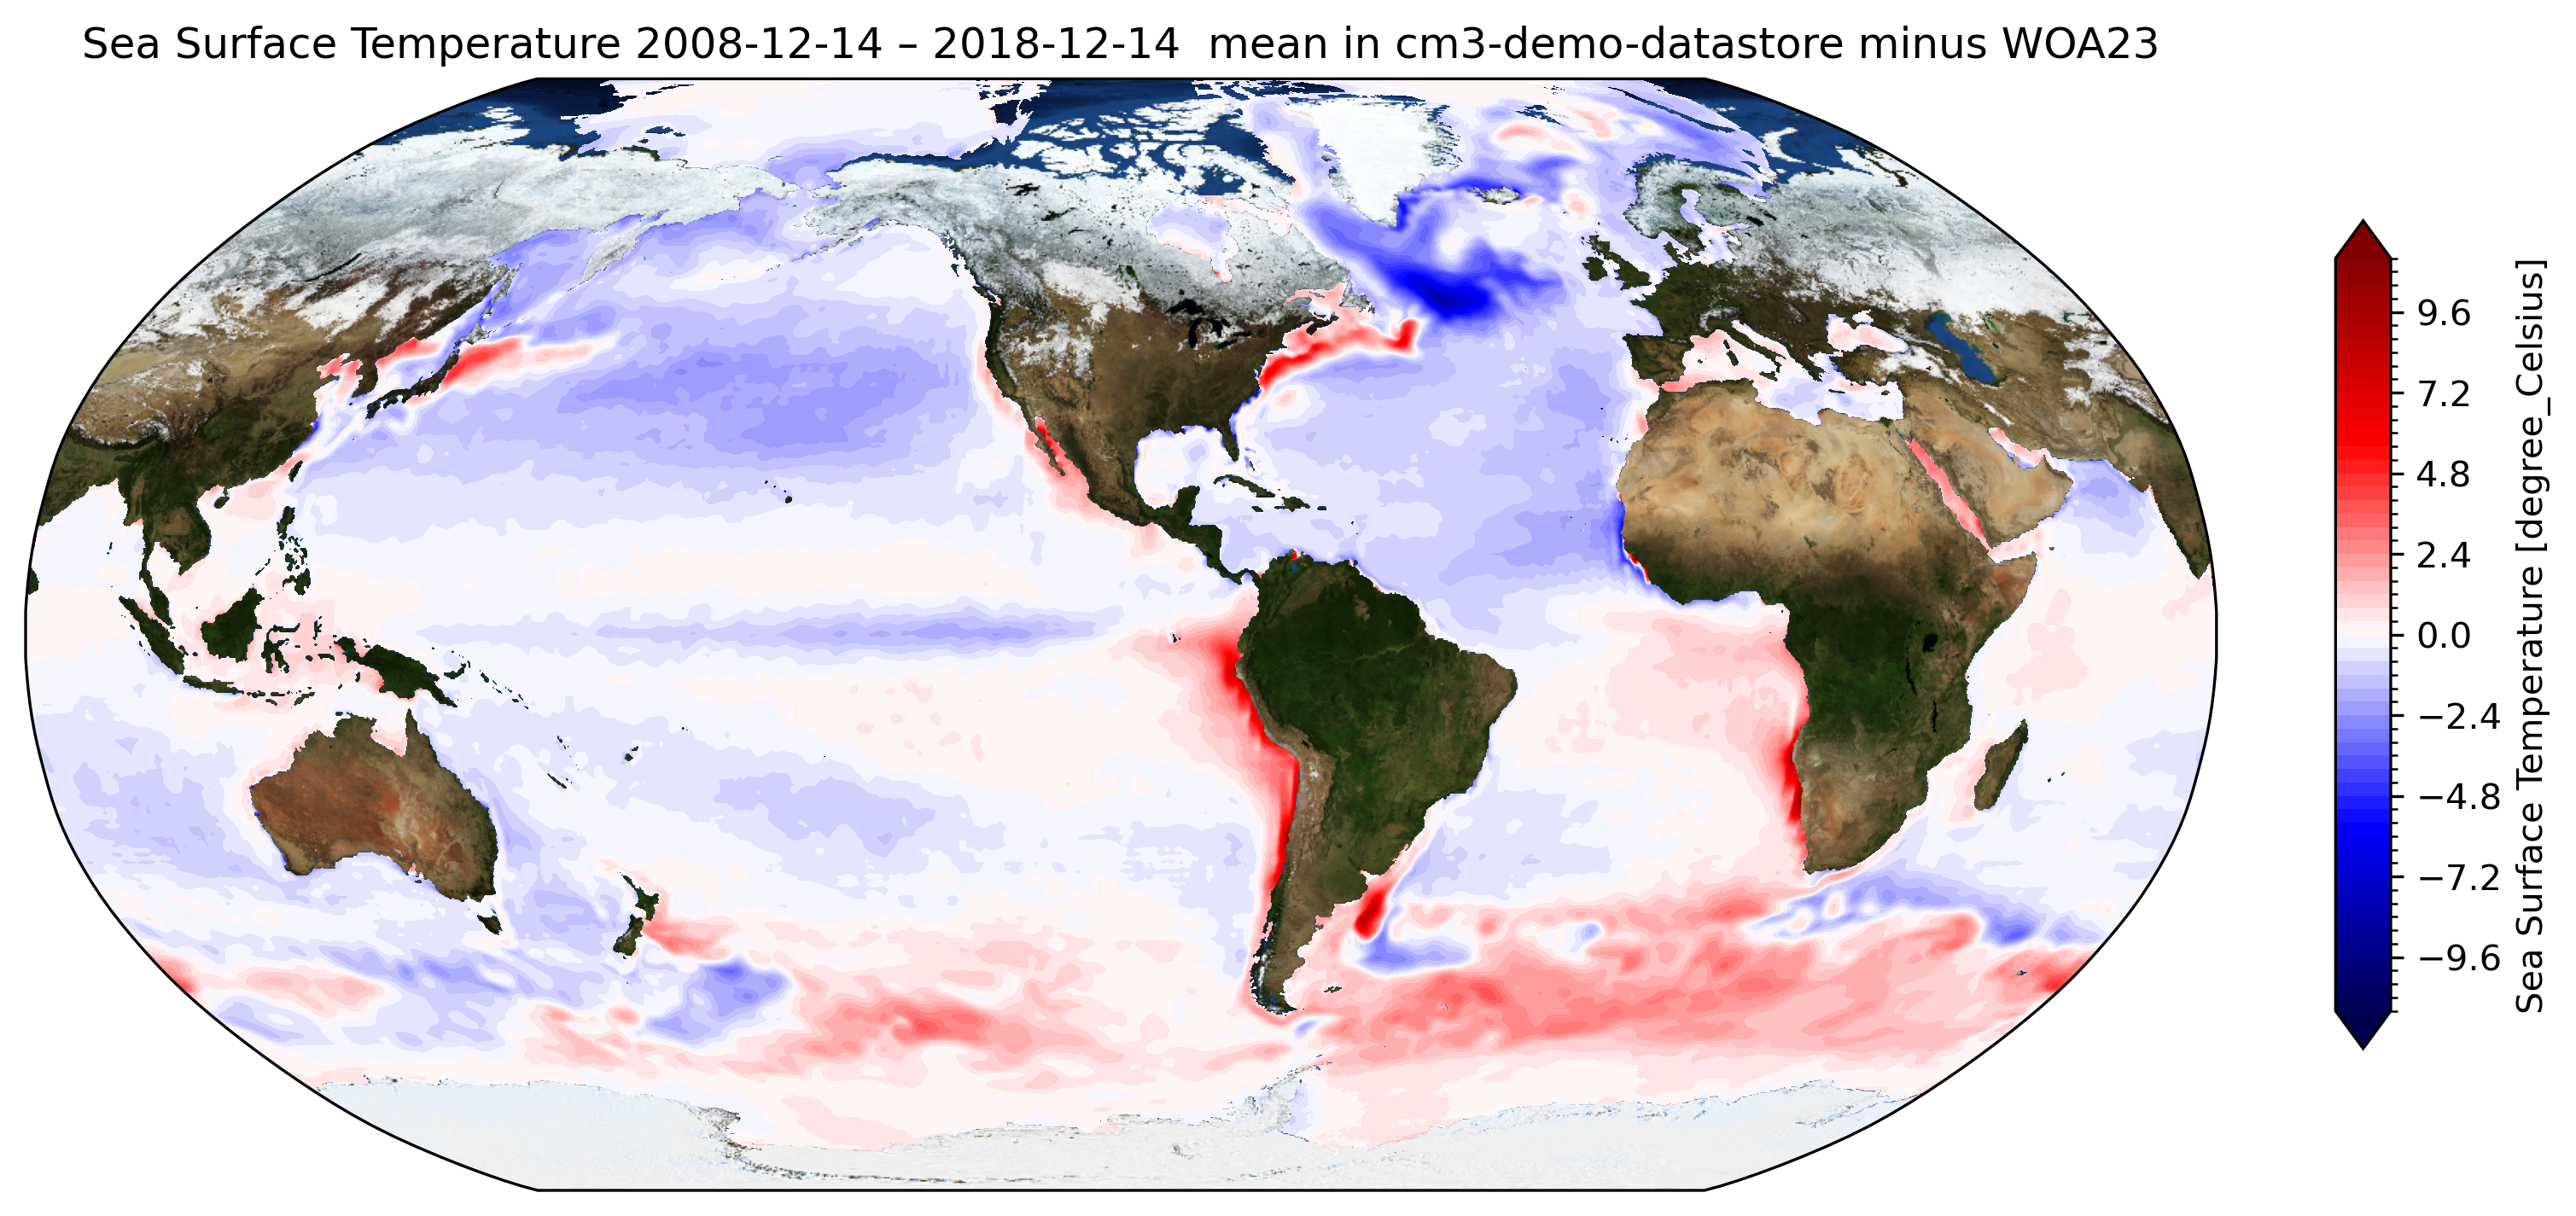

In [133]:
# 1) Interpolate obs to the model grid using CF longitude & latitude
obs_on_model = obs.cf.interp(
    longitude=model.cf["longitude"],
    latitude=model.cf["latitude"],
)

# 2) Compute bias directly (units already consistent)
bias = (model - obs_on_model).load()

# 3) Plot the bias
long_name = model.attrs.get("long_name", "SST")

plot(
    bias,
    levels=61,
    extend="both",
    cmap="seismic",
    title=(
        f"{long_name} "
        f"{datestart.strftime('%Y-%m-%d')} – {datestop.strftime('%Y-%m-%d')} "
        f" mean in {exptname} minus WOA23"
    ),
)

In [ ]:
plot(
    bias,
    levels=61,
    vmin=-3,
    vmax=3,
    extend="both",
    cmap="seismic",
    title=(
        f"{long_name} "
        f"{datestart.strftime('%Y-%m-%d')} – {datestop.strftime('%Y-%m-%d')} "
        f"in mean in {exptname} minus WOA23"
    ),
)


In [ ]:
client.close()